# DEEP LEARNING
## Assignment 2 - Time series forecasting
In this assigment we are given a 1000 points univariate time series
where our objective is to predict the values of the following 200 points.

In [27]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn import preprocessing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [31]:
time_series: np.ndarray = loadmat('data/Xtrain.mat')['Xtrain']
#time_series: np.ndarray = np.loadtxt('data/Xtrain.csv', delimiter=',')
#time_series = np.reshape(time_series, newshape=(time_series.shape[0], 1))
data_points = time_series.shape[0]
print(data_points)

1000


Plotting of the time series

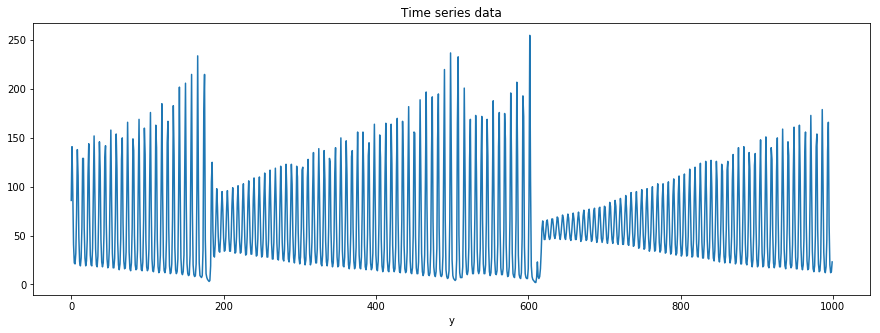

In [29]:
plt.figure(1, figsize=[15, 5])
plt.plot(time_series)
plt.xlabel('x')
plt.xlabel('y')
plt.title('Time series data')
plt.show()

First we are going to analyze the time series, to see
if we can extract valuable information about the time series that
help us regarding to the configuration of the network. For example, 
we can check the autocorrelation and the partial autocorrelation:

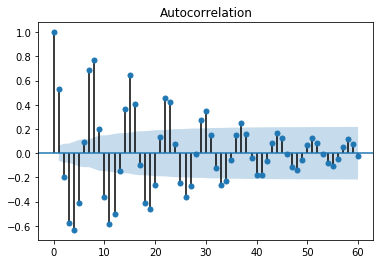

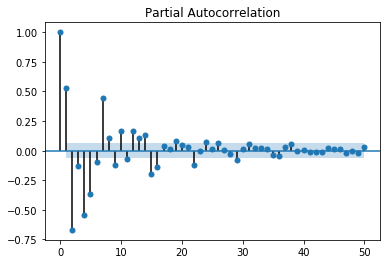

In [30]:
plot_acf(time_series, lags=60)
plt.show()
plot_pacf(time_series, lags=50)
plt.show()

We can observe in both plots, the autocorrelation and partial 
autocorrelation, that there is an influence in the value of a point
and the previous points. This influence lasts for at least 40 points,
when the influence falls under the confidence interval. 

This could give us a hint about the time windows.

### Preprocessing
In order to work with the dataset, we are going to __normalize__ it,
scaling it between [-1,1]. The _MinMaxScaler_ object will be used
later to denormalize also.

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
time_series = min_max_scaler.fit_transform(time_series)

In order to face this problem, we are going to use a rolling windows
that will go along the time series. At each step, constant size 
features (inputs) and outputs are extracted, and therefore each series
can be a source of many input/output records.

One of the best loss measures for this kind of data is the Root
Mean Squared Error (RMSE) that we will implement in order to use it
in the Keras framework.

In [32]:
from keras import backend

def root_mean_square_error(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

Using TensorFlow backend.


At first, we are going to use the following structure:

- __Input__: [x(1), x(2), ..., x(time_windows)]
- __Output__: [x(time_windows + 1)]

In this way, we will predict the following step of a given input,
that will be used for the following prediction.

To process the data, we will use the following function:

In [ ]:
def process_data(data: np.ndarray, window_size: int, 
                 dimensions: int = 2) -> Tuple[np.ndarray, np.ndarray]:
    """
    Method that process a time series and creates the data required to train and test the
    neural network.

    For example, for a windows of size 3:

    [1, 2, 3, 4, 5] ->  [[1, 2, 3], [2, 3, 4]]; [[4], [5]]

    :param data: time series data
    :param window_size: number of data points that are included in the x elements
    :param dimensions: dimensionality of the data, 2D or 3D depending of the network
    :return: tuple with the values of x and y and the specified shapes
    """
    n_possible_elements = data.shape[0] - window_size - 1
    if dimensions == 2:
        shape_x = (window_size,)
        shape_y = (1,)
    else:
        shape_x = (window_size, 1)
        shape_y = (1, 1)
    x = np.empty((n_possible_elements,) + shape_x)
    y = np.empty((n_possible_elements,) + shape_y)
    for i in range(n_possible_elements):
        end = i + window_size
        x_element = np.reshape(data[i:end], newshape=shape_x)
        y_element = np.reshape(data[end], newshape=shape_y)
        x[i] = x_element
        y[i] = y_element
    return x, y

